In [1]:
# !pip install konlpy
# !pip install wordcloud

# !pip install pyLDAvis

# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

> ### 패키지 불러오기

In [2]:
import re
from datetime import datetime
from time import time
import collections

import requests, json
from bs4 import BeautifulSoup
import urllib.parse as parse

from tqdm import tqdm
import pickle
from pprint import pprint as print

import numpy as np
import pandas as pd
import sklearn as sk

from konlpy.tag import Okt, Komoran # komoran, hannanum, kkma, mecab
import gensim
from gensim.summarization import summarize

# visualization
import matplotlib as mpl
import matplotlib.pylab as plb
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rcParams
import seaborn as sns
from wordcloud import WordCloud
import pyLDAvis.gensim_models

# 브라우저에서 바로 그려지도록 
# %matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# # Colab 의 한글 폰트 설정
# plt.rc('font', family='NanumSquareRound') 

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

# Seaborn 테마 설정
sns.set_theme(style="ticks", color_codes=True, font='NanumSquareRound', font_scale=2)

# 워닝 메세지 삭제
import warnings
warnings.filterwarnings(action='ignore')

# font_list = [font.name for font in fm.fontManager.ttflist]
# font_list

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


> ### 폰트 선택

In [3]:
font_list = [font.name for font in fm.fontManager.ttflist]
font_list
font_path = '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'

> ### 전처리

In [4]:
df = pd.read_csv('러시아 한국 경제_v2_2022041520220224.csv')

In [5]:
def clean_content(content):
  stripped = content[69:-2]
  cleaned = re.sub('[^가-힣ㄱ-ㅣa-zA-Z|0-9.%]', ' ', string=stripped)
  return cleaned

def clean_title(title):
  cleaned = re.sub('[^가-힣ㄱ-ㅣa-zA-Z|0-9.%]', ' ', string=title)
  return cleaned

In [6]:
df['내용'] = df['내용'].apply(clean_content)
df['제목'] = df['제목'].apply(clean_title) + '.'
df['제목내용'] = df['제목'] + ' ' + df['내용']

> ### 사용자 사전 추가 & 토큰화

In [7]:
kmr = Komoran(userdic='user_dictionary.txt')
# kmr = Komoran()

In [8]:
preprocessed = df['제목내용'].apply(kmr.nouns)

> ### 불용어 삭제

In [9]:
with open('stopwords.pickle', 'rb') as f:
  stopwords = pickle.load(f)
with open('news_lst.pickle', 'rb') as f:
  news_lst = pickle.load(f)

more_sw = [
           '정은',
           '정부',
           '일보',
           '유사점',
           '소우',
           '권위',
           '인텔리전스',
           '피켓',
           '회장',
           '결',
           '김화영',
           '벡스',
           '유승준',
           '최경영',
           '현수',
           '소프',
           '경식',
           '입찰'
           '다운로드',
           '스토어',
           '유닛',
           '극동방송',
           '석관',
           '스트리트',
           'WP',
           '평론가',
           '320',
           '승관',
           '이데일리TV',
           '김준형',
           '정철',
           '이완용',
           '악주',
]
stopwords.extend(news_lst)
stopwords.extend(more_sw)

In [10]:
# 불용어 삭제 함수
# 한글자 단어도 삭제

def sw_rmv(row):
  lst = []
  for el in row:
    if el not in stopwords and len(el) > 1:
      lst.append(el)
  return lst

In [11]:
preprocessed = preprocessed.apply(sw_rmv)

> ### 트라이그램화

In [12]:
def to_trigrams(row):
  bigram = gensim.models.Phrases(row, delimiter=b' ')
  trigram = gensim.models.Phrases(bigram[row], delimiter=b' ')  
  bigram_mod = gensim.models.phrases.Phraser(bigram)
  trigram_mod = gensim.models.phrases.Phraser(trigram)
  bigrammed = bigram_mod[row]
  trigrammed = trigram_mod[bigrammed]
  
  return trigrammed

In [13]:
preprocessed = preprocessed.apply(to_trigrams)

> ### TF*IDF 구축

In [14]:
dictionary = gensim.corpora.Dictionary(preprocessed) # 토큰별 아이디 부여

In [15]:
corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in preprocessed] # BoW Corpus 생성

In [16]:
tfidf = gensim.models.TfidfModel(corpus, smartirs='ntc') # TF*IDF 생성

In [17]:
tfidf_dic = {dictionary.get(id): freq for doc in tfidf[corpus] for id, freq in doc}

In [18]:
toDataFrame = {
  '단어': tfidf_dic.keys(),
  '빈도': tfidf_dic.values(),    
}

In [19]:
w = WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=1000, font_path = font_path).fit_words(tfidf_dic)

In [20]:
plt.figure(figsize=(20,15))
plt.imshow(w)
plt.axis('off')
plt.savefig('러시아 한국 경제 워드클라우드_1000.png')

Output hidden; open in https://colab.research.google.com to view.

In [21]:
w_500 = WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=500, font_path = font_path).fit_words(tfidf_dic)

In [22]:
plt.figure(figsize=(20,15))
plt.imshow(w_500)
plt.axis('off')
plt.savefig('러시아 한국 경제 워드클라우드_500.png')

Output hidden; open in https://colab.research.google.com to view.

In [23]:
w_100 = WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=100, font_path = font_path).fit_words(tfidf_dic)

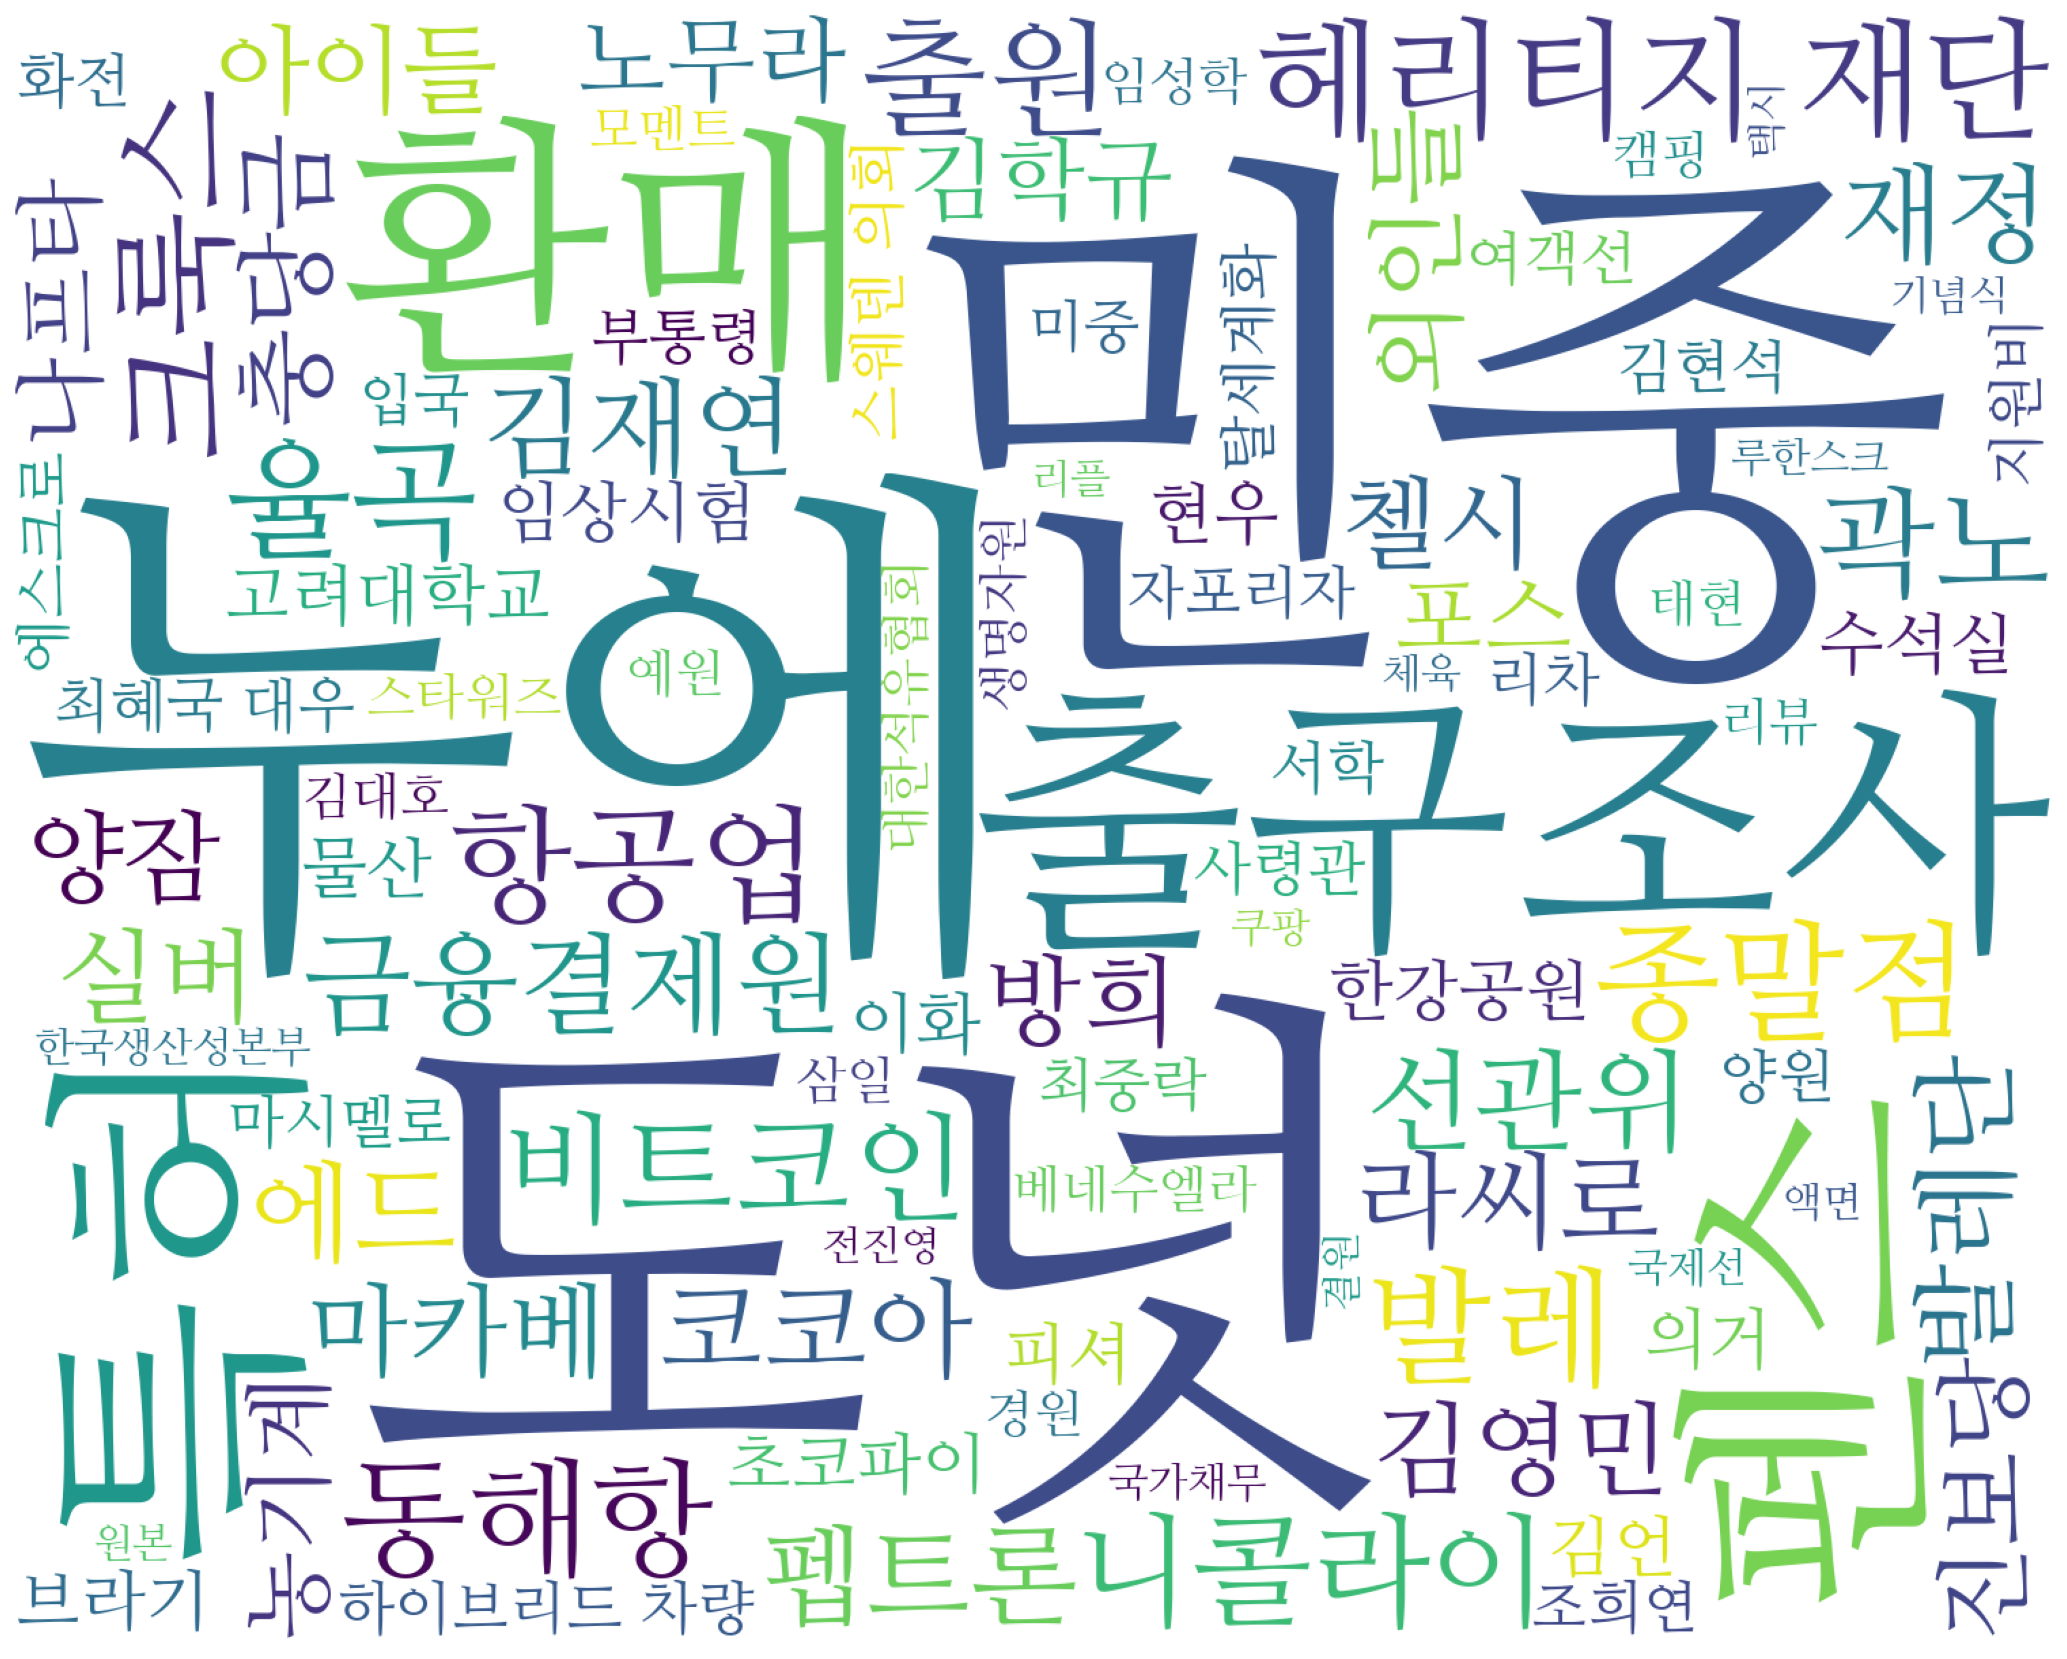

In [24]:
plt.figure(figsize=(20,15))
plt.imshow(w_100)
plt.axis('off')
plt.savefig('러시아 한국 경제 워드클라우드_100.png')

In [25]:
od = {v: k for k, v in tfidf_dic.items()}

In [26]:
ordered_keys = sorted(od.keys())

In [27]:
tfidf_od = {od[k]: k for k in ordered_keys}

In [28]:
keys = list(tfidf_od.keys())
keys.reverse()
for i in range(50):
  key = keys[i]
  print(f'{key}, {tfidf_od[key]}')

'민중, 0.8151214841421601'
'도넛, 0.803374813344695'
'누에, 0.7699420599166359'
'출구조사, 0.6885914341962314'
'환매, 0.6880097563524271'
'펜스, 0.6707000712751197'
'특허, 0.6695098137547316'
'헤리티지 재단, 0.6556994421452238'
'크룩스, 0.6431103584140476'
'율곡, 0.64074502873785'
'종말점, 0.6386187791684115'
'발레, 0.6292837594986157'
'항공업, 0.6280071372514081'
'동해항, 0.6265669956764577'
'출원, 0.6253103816604849'
'니콜라이, 0.6199678536868015'
'곽노, 0.6025632318969776'
'비트코인, 0.596250235378385'
'금융결제원, 0.5927435905966221'
'선관위, 0.588903301578409'
'펩트론, 0.5803815304920433'
'에드, 0.5708418886692468'
'코코아, 0.5670908839662572'
'김재연, 0.5650771497382986'
'재정, 0.5634120457450659'
'발레단, 0.5593633417765472'
'라씨로, 0.5480288287823274'
'김영민, 0.5479016213944791'
'실버, 0.5441933695340594'
'마카베, 0.5389222268783316'
'충당금, 0.5294621361277285'
'양잠, 0.5219946168926345'
'외인들, 0.5175754930651107'
'첼시, 0.5175355300561706'
'방희, 0.5074959039104183'
'진보당, 0.5022907997673765'
'아이들, 0.5012644394144684'
'노무라, 0.48672158052754233'
'나프타, 0.484019399134724